## Importing Essential Libraries

In [3]:
#Required libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## Data File and Target Feature Specification

This cell defines two key variables for our analysis:

- **`data_file_name`:** This variable stores the name of the CSV file containing our dataset. In this case, it's set to 'churn_data.csv'.

- **`targetF`:** This variable specifies the name of the column in our dataset that represents the target feature we want to predict or analyze. Here, it's set to 'Churn_Sim_Nao', indicating that we're interested in predicting customer churn.

In [4]:
# File name to be read:
data_file_name = 'churn_data.csv'

# Target feature for prediction:
targetF = 'Churn_Sim_Nao'

## Importing the Dataset

This cell imports the dataset from the CSV file specified by the `data_file_name` variable. The `pd.read_csv` function is used to read the CSV file and create a pandas DataFrame. The `sep=";"` argument indicates that the data in the CSV file is separated by semicolons.

The `df.head()` method then displays the first few rows of the DataFrame, providing a preview of the data structure and content.

In [5]:
#Importing the database
df = pd.read_csv(data_file_name, sep=";")
df.head()

,ClientId,DataÚltimaTransição,Dias Inativos,Churn_Sim_Nao,Score_Credito,Estado,G_nero,Idade,Tempo_Cliente_Meses,Limite_Credito_Mercado,Qte_Categorias,Usa_Cartao_Credito,Programa_Fidelidade,Sum_Acumulado
0,345568,14/09/2019,46,1,619,São Paulo,Feminino,42,2,0,1,1,1,"$422,29"
1,345569,05/10/2019,25,0,608,Rio de Janeiro,Feminino,41,1,"838,1",1,0,1,"R$ 468,93"
2,345570,20/08/2019,71,1,502,São Paulo,Feminino,42,8,"1596,6",3,1,0,"$474,71"
3,345571,21/10/2019,9,0,699,São Paulo,Feminino,39,1,0,2,0,0,"$390,94"
4,345572,26/10/2019,4,0,850,Rio de Janeiro,Feminino,43,2,"1255,1",1,1,1,"$329,52"


## Information Value (IV) Calculation

This function calculates the Information Value (IV) for each independent variable in the dataset. IV is a measure of how well a variable can separate or distinguish between different classes (e.g., churn vs. non-churn). Higher IV values indicate better separation power.

The function works as follows:

1. **Initialization:**
   - An empty DataFrame `iv_df` is created to store the IV results.
   - The column names of the dataset are retrieved.

2. **Categorization of Separation Power:**
   - A nested function `categorize_separation_power` is defined to categorize the separation power based on the calculated IV value. Categories include "Very Weak," "Weak," "Medium," "Strong," and "Very Strong (Verify!)".

3. **IV Calculation Loop:**
   - The function iterates through each independent variable (excluding the target variable).
   - For each variable:
     - **Binning:** If the variable is numeric and has more than 10 unique values, it is binned using quantiles.
     - **Group and Calculate Statistics:** The data is grouped by the binned variable or the original variable (if not binned). Statistics like count and sum of the target variable are calculated for each group.
     - **Calculate Percentages and WoE:** Percentages of events and non-events, as well as the Weight of Evidence (WoE), are calculated for each group.
     - **Calculate IV:** The IV for the variable is calculated and stored along with the variable name.

4. **Separation Power Category:**
   - The separation power category is added to the `iv_df` based on the calculated IV values.

5. **Sorting and Return:**
   - The `iv_df` is sorted by IV in descending order and returned.

In [8]:
def calculate_iv(data, target, bins=10):
    """Calculate Information Value (IV) for each independent variable."""
    iv_df = pd.DataFrame()  # Empty DataFrame for IV results
    cols = data.columns  # Get column names

    def categorize_separation_power(iv):
        """Categorizes separation power based on IV value."""
        if iv < 0.02:
            return "Very Weak"
        elif iv < 0.1:
            return "Weak"
        elif iv < 0.3:
            return "Medium"
        elif iv < 0.5:
            return "Strong"
        else:
            return "Very Strong (Verify!)"

    # Calculate IV for each independent variable
    for ivars in cols[~cols.isin([target])]:
        # Binning logic (same as before)
        if (data[ivars].dtype.kind in 'bifc') and (len(np.unique(data[ivars])) > 10):
            binned_x = pd.qcut(data[ivars], bins, duplicates='drop')
            d0 = pd.DataFrame({'x': binned_x, 'y': data[target]})
        else:
            d0 = pd.DataFrame({'x': data[ivars], 'y': data[target]})

        # Group data and calculate statistics
        d = d0.groupby("x", as_index=False).agg({"y": ["count", "sum"]})
        d.columns = ['Cutoff', 'N', 'Events']

        # Calculate percentages and WoE
        d['% of Events'] = np.maximum(d['Events'], 0.5) / d['Events'].sum()
        d['Non-Events'] = d['N'] - d['Events']
        d['% of Non-Events'] = np.maximum(d['Non-Events'], 0.5) / d['Non-Events'].sum()
        d['WoE'] = np.log(d['% of Events'] / d['% of Non-Events'])

        # Calculate IV and add variable name
        d['IV'] = d['WoE'] * (d['% of Events'] - d['% of Non-Events'])
        d.insert(loc=0, column='Variable', value=ivars)

        # Store IV result
        temp = pd.DataFrame({"Variable": [ivars], "IV": [d['IV'].sum()]}, columns=["Variable", "IV"])
        iv_df = pd.concat([iv_df, temp], axis=0)

    # Add separation power category
    iv_df['Separation Power'] = iv_df['IV'].apply(categorize_separation_power)

    # Sort by IV (descending) and separation power category (ascending)
    iv_df = iv_df.sort_values(by=['IV'], ascending=[False])

    return iv_df

### Calculating and Displaying Variable Rankings by Information Value (IV)

In [9]:
# Example usage (replace 'classif' with your actual target variable)
ranking = calculate_iv(data=df, target=targetF)
ranking

,Variable,IV,Separation Power
0,Dias Inativos,14.658088,Very Strong (Verify!)
0,DataÚltimaTransição,10.012572,Very Strong (Verify!)
0,Sum_Acumulado,2.357581,Very Strong (Verify!)
0,Limite_Credito_Mercado,1.473030,Very Strong (Verify!)
0,Qte_Categorias,0.931941,Very Strong (Verify!)
0,Idade,0.770763,Very Strong (Verify!)
0,Estado,0.166786,Medium
0,Programa_Fidelidade,0.151655,Medium
0,G_nero,0.072979,Weak
0,Score_Credito,0.010236,Very Weak


## Functions for Feature Separation: Quantitative and Qualitative

These functions are designed to separate the columns of a DataFrame into quantitative and qualitative features based on their data types:

**1. `separate_quantitative(df)`:**

   - This function takes a DataFrame `df` as input.
   - It uses the `select_dtypes` method to select only columns that have numeric data types (e.g., integers, floats). These columns represent quantitative features.
   - The function returns a new DataFrame containing only the quantitative columns.

**2. `separate_qualitative(df)`:**

   - This function also takes a DataFrame `df` as input.
   - It uses the `select_dtypes` method with the `exclude=['number']` argument to select columns that are *not* numeric. These columns represent qualitative features (e.g., strings, categories).
   - The function returns a new DataFrame containing only the qualitative columns.

In [10]:
def separate_quantitative(df):
    """
    Separates quantitative columns from a DataFrame.

    Args:
        df (pd.DataFrame): The DataFrame to process.

    Returns:
        pd.DataFrame: A DataFrame containing only quantitative columns.
    """
    return df.select_dtypes(include=['number'])

def separate_qualitative(df):
    """
    Separates qualitative columns from a DataFrame.

    Args:
        df (pd.DataFrame): The DataFrame to process.

    Returns:
        pd.DataFrame: A DataFrame containing only qualitative columns.
    """
    return df.select_dtypes(exclude=['number'])

### Call the functions and Now you have 'quantitative_df' and 'qualitative_df' for further analysis

In [11]:
quantitative_df = separate_quantitative(df)
qualitative_df = separate_qualitative(df)

In [12]:
# Calling
qualitative_df

,DataÚltimaTransição,Estado,G_nero,Limite_Credito_Mercado,Sum_Acumulado
0,14/09/2019,São Paulo,Feminino,0,"$422,29"
1,05/10/2019,Rio de Janeiro,Feminino,"838,1","R$ 468,93"
2,20/08/2019,São Paulo,Feminino,"1596,6","$474,71"
3,21/10/2019,São Paulo,Feminino,0,"$390,94"
4,26/10/2019,Rio de Janeiro,Feminino,"1255,1","$329,52"
...,...,...,...,...,...
9995,05/10/2019,São Paulo,Masculino,0,"$401,13"
9996,06/10/2019,São Paulo,Masculino,"573,7","$423,75"
9997,21/07/2019,São Paulo,Feminino,0,"$175,36"
9998,19/08/2019,Minas Gerais,Masculino,"750,8","$387,04"


In [13]:
#Calling
quantitative_df

,ClientId,Dias Inativos,Churn_Sim_Nao,Score_Credito,Idade,Tempo_Cliente_Meses,Qte_Categorias,Usa_Cartao_Credito,Programa_Fidelidade
0,345568,46,1,619,42,2,1,1,1
1,345569,25,0,608,41,1,1,0,1
2,345570,71,1,502,42,8,3,1,0
3,345571,9,0,699,39,1,2,0,0
4,345572,4,0,850,43,2,1,1,1
...,...,...,...,...,...,...,...,...,...
9995,355563,25,0,771,39,5,2,1,0
9996,355564,24,0,516,35,10,1,1,1
9997,355565,101,1,709,36,7,1,0,1
9998,355566,72,1,772,42,3,2,1,0


## Descriptive Summary of Quantitative Variables

This code calculates and displays a descriptive summary for all quantitative variables (numeric columns) in the DataFrame `df`.

**Steps:**

1. **Function Definition:**
   - The `describe_quantitative_variables` function is defined. It takes a DataFrame as input and returns a DataFrame containing the descriptive summary.

2. **Quantitative Variable Selection:**
   - Inside the function, `df.select_dtypes(include=['number'])` selects only the columns with numeric data types, representing quantitative variables.

3. **Descriptive Statistics Calculation:**
   - The `describe()` method is applied to the quantitative DataFrame. This method calculates various descriptive statistics, including:
     - Count: The number of non-null values.
     - Mean: The average value.
     - Standard deviation (std): A measure of how spread out the data is.
     - Minimum (min): The smallest value.
     - Quartiles (25%, 50%, 75%): Values that divide the data into fourths.
     - Maximum (max): The largest value.

4. **Return Summary:**
   - The function returns the DataFrame containing the calculated descriptive statistics.

**Example Usage:**

- The code assumes you have a DataFrame named `df`.
- It calls the `describe_quantitative_variables` function with `df` as input and stores the result in `descriptive_summary`.
- Finally, it displays the `descriptive_summary` DataFrame, allowing you to view the descriptive statistics for each quantitative variable in your dataset.

In [14]:
import pandas as pd

def describe_quantitative_variables(df):
    """
    Creates a descriptive summary for all quantitative variables in the DataFrame.

    Args:
        df (pd.DataFrame): The DataFrame containing quantitative variables.

    Returns:
        pd.DataFrame: A DataFrame containing the descriptive summary for quantitative variables.
    """

    # Select only the quantitative variables (columns with numeric data types)
    quantitative_df = df.select_dtypes(include=['number'])

    # Generate descriptive statistics using the describe() method
    # This includes count, mean, standard deviation, minimum, quartiles, and maximum
    summary = quantitative_df.describe()

    # Return the DataFrame containing the descriptive summary
    return summary

# Assuming 'df' is your DataFrame
descriptive_summary = describe_quantitative_variables(df)

# Display the descriptive summary
descriptive_summary

,ClientId,Dias Inativos,Churn_Sim_Nao,Score_Credito,Idade,Tempo_Cliente_Meses,Qte_Categorias,Usa_Cartao_Credito,Programa_Fidelidade
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000
mean,350567.50000,26.906500,0.201300,650.528800,38.921800,5.012800,1.530200,0.70550,0.515100
std,2886.89568,28.369234,0.400992,96.653299,10.487806,2.892174,0.581654,0.45584,0.499797
min,345568.00000,0.000000,0.000000,350.000000,18.000000,0.000000,1.000000,0.00000,0.000000
25%,348067.75000,9.000000,0.000000,584.000000,32.000000,3.000000,1.000000,0.00000,0.000000
50%,350567.50000,18.000000,0.000000,652.000000,37.000000,5.000000,1.000000,1.00000,1.000000
75%,353067.25000,28.000000,0.000000,718.000000,44.000000,7.000000,2.000000,1.00000,1.000000
max,355567.00000,121.000000,1.000000,850.000000,92.000000,10.000000,4.000000,1.00000,1.000000


## Visualization of Quantitative Features

This function creates a histogram and a boxplot for each quantitative feature (numeric column) in the DataFrame `df`.

**Steps:**

1. **Function Definition:**
   - The `visualize_quantitative` function is defined. It takes a DataFrame as input and generates the visualizations.

2. **Iteration over Columns:**
   - The function iterates through each column in the DataFrame.

3. **Subplot Creation:**
   - For each column, a figure with two subplots is created using `plt.subplots(1, 2, figsize=(12, 5))`. This will accommodate the histogram and boxplot side-by-side.

4. **Histogram:**
   - A histogram is created for the current column using `axs[0].hist`. The `bins='auto'` argument automatically calculates the number of bins. Visual enhancements like linewidth and edge color are applied.
   - The x-axis labels are rotated for readability, and font sizes are adjusted.

5. **Boxplot:**
   - A boxplot is created for the current column using `axs[1].boxplot`. 
   - Customization options are applied:
     - `patch_artist=True`: Allows filling the box with color.
     - `showmeans=False`: Hides the mean marker.
     - `showfliers=False`: Hides outlier points.
     - `medianprops`, `boxprops`, `whiskerprops`, and `capprops` dictionaries are used to customize the appearance of the median line, box, whiskers, and caps, respectively.

6. **Titles and Layout:**
   - Titles are set for both the histogram and boxplot subplots.
   - A suptitle (overall figure title) is added using `plt.suptitle`.
   - `plt.tight_layout()` adjusts the layout to prevent overlapping elements.

7. **Display:**
   - `plt.show()` displays the generated figure with the histogram and boxplot.

In [15]:
import matplotlib.pyplot as plt
import pandas as pd

def visualize_quantitative(df):
    """
    Creates histogram and boxplot for quantitative features.

    Args:
        df (pd.DataFrame): The DataFrame containing quantitative features.
    """
    for col in df.columns:
        fig, axs = plt.subplots(1, 2, figsize=(12, 5))

        # Histogram (without percentage labels)
        axs[0].hist(df[col], bins='auto', linewidth=0.5, edgecolor="white")
        axs[0].set_title(f"Histogram of {col}")
        plt.xticks(rotation=45)
        plt.xticks(fontsize=8)
        plt.yticks(fontsize=8)

        # Boxplot with min, max, and median
        axs[1].boxplot(
            df[col],
            patch_artist=True,
            showmeans=False,
            showfliers=False,
            medianprops={"color": "white", "linewidth": 0.5},
            boxprops={"facecolor": "C0", "edgecolor": "white", "linewidth": 0.5},
            whiskerprops={"color": "C0", "linewidth": 1.5},
            capprops={"color": "C0", "linewidth": 1.5},
        )
        axs[1].set_title(f"Boxplot of {col}")

        
        plt.suptitle(f"Visualizations for {col}", y=1.01)
        plt.tight_layout()
        plt.show()

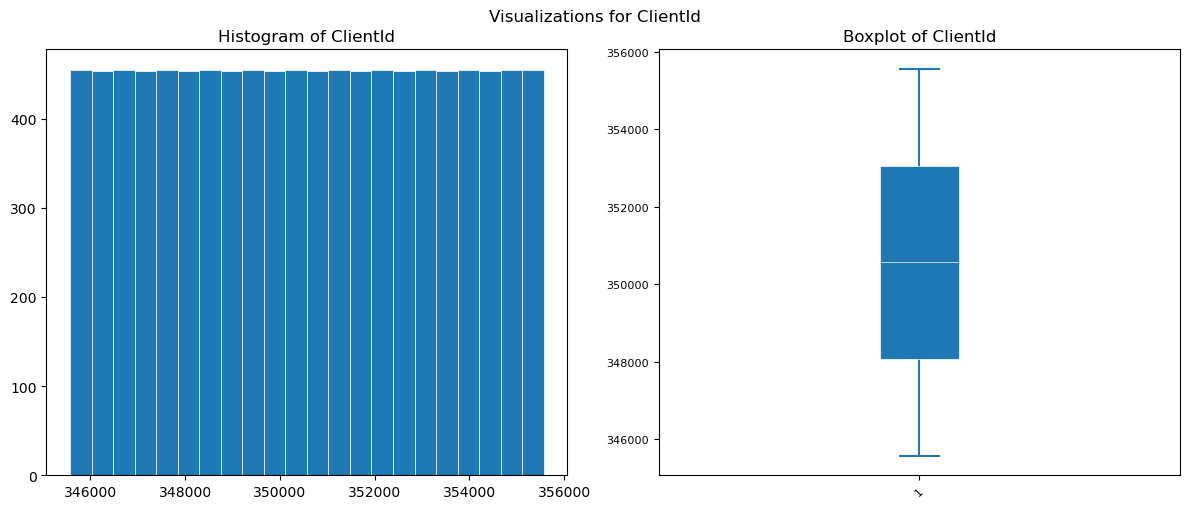

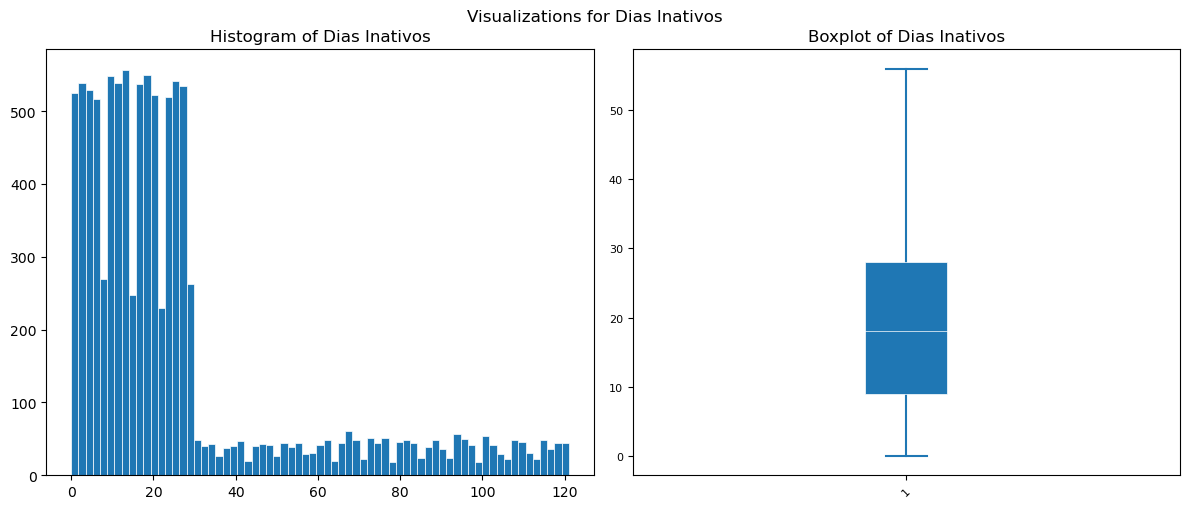

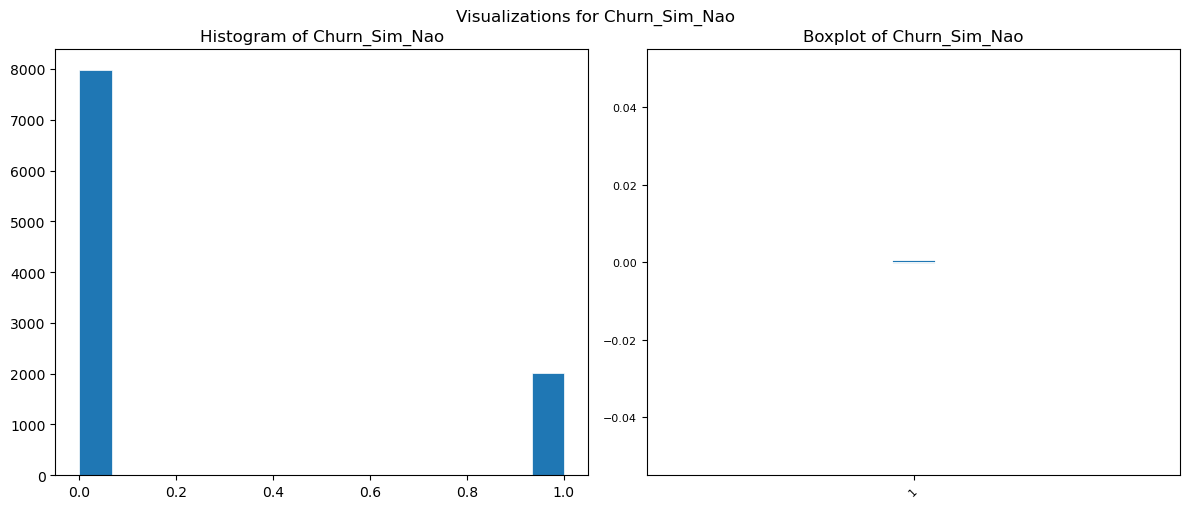

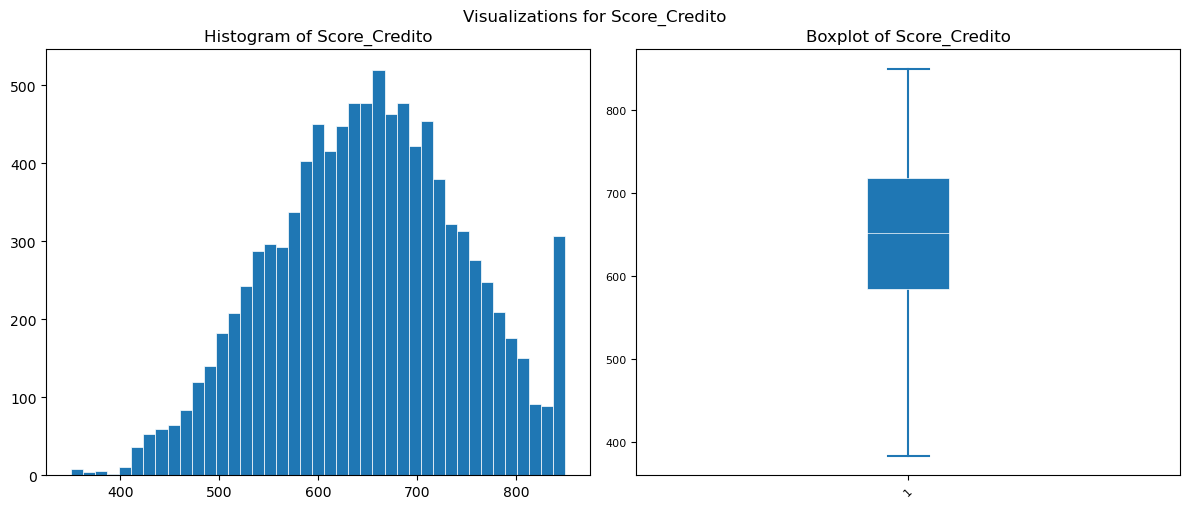

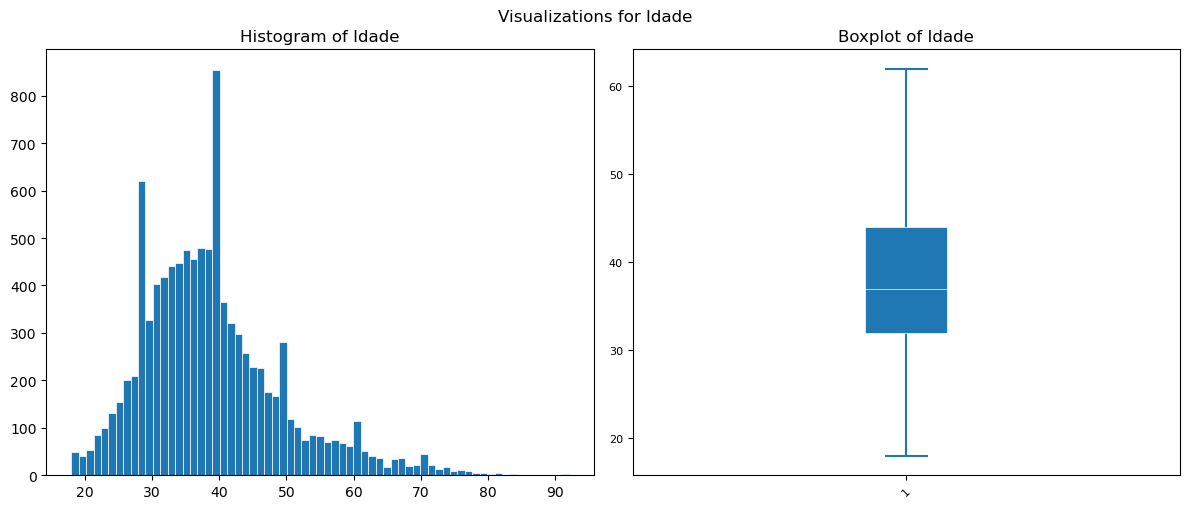

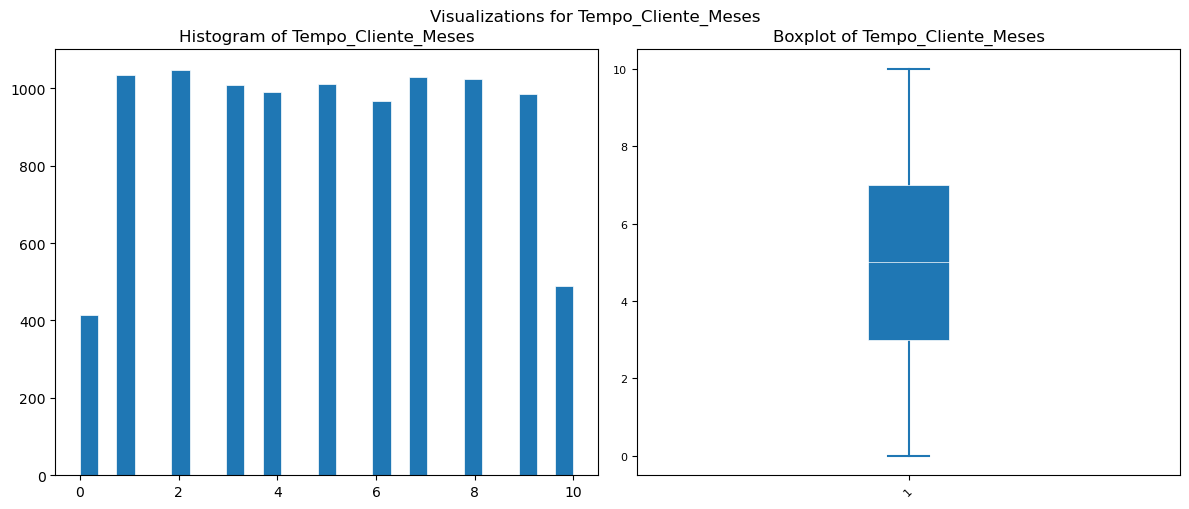

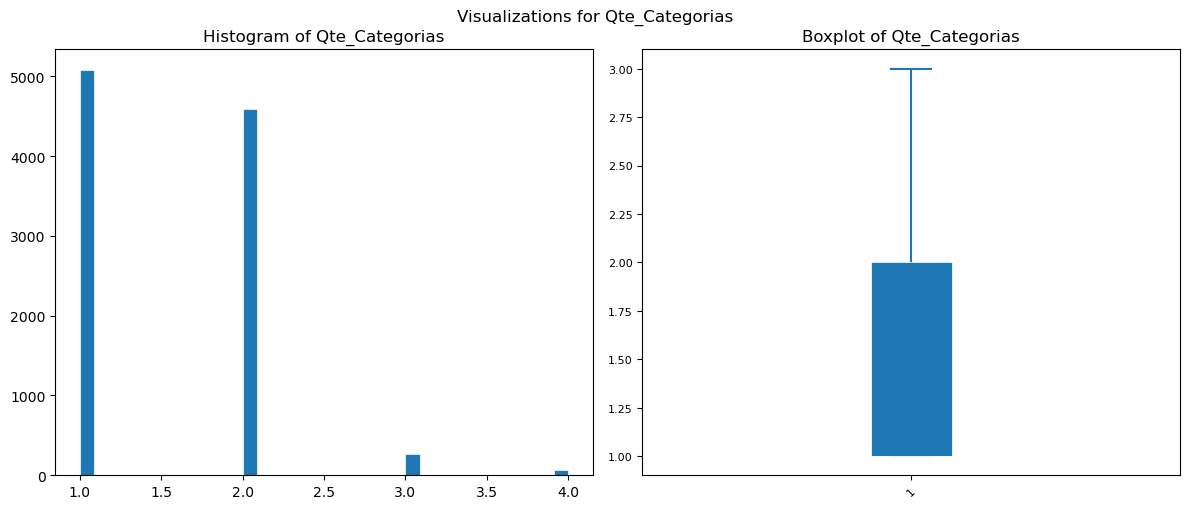

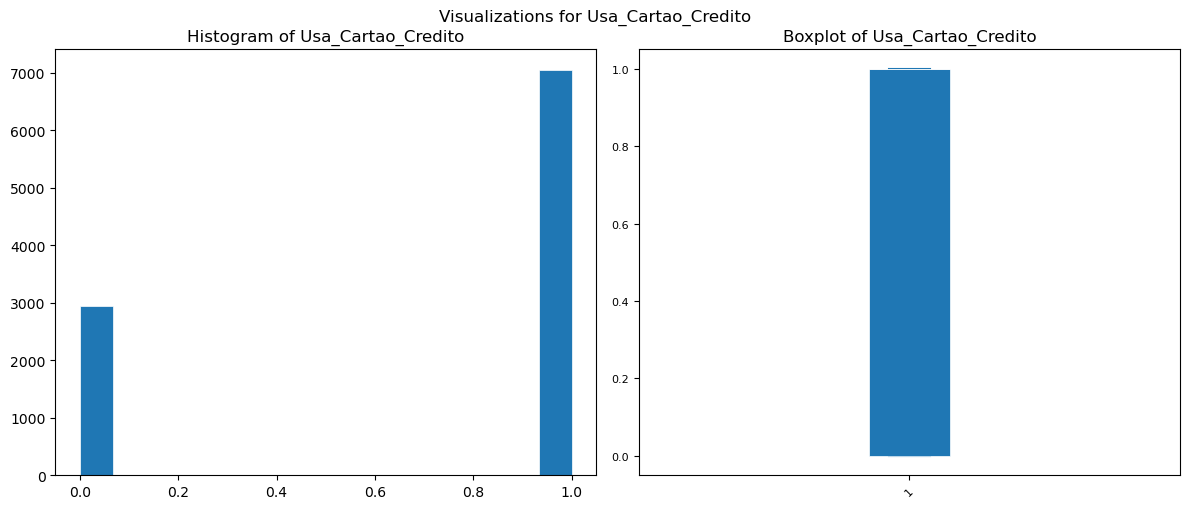

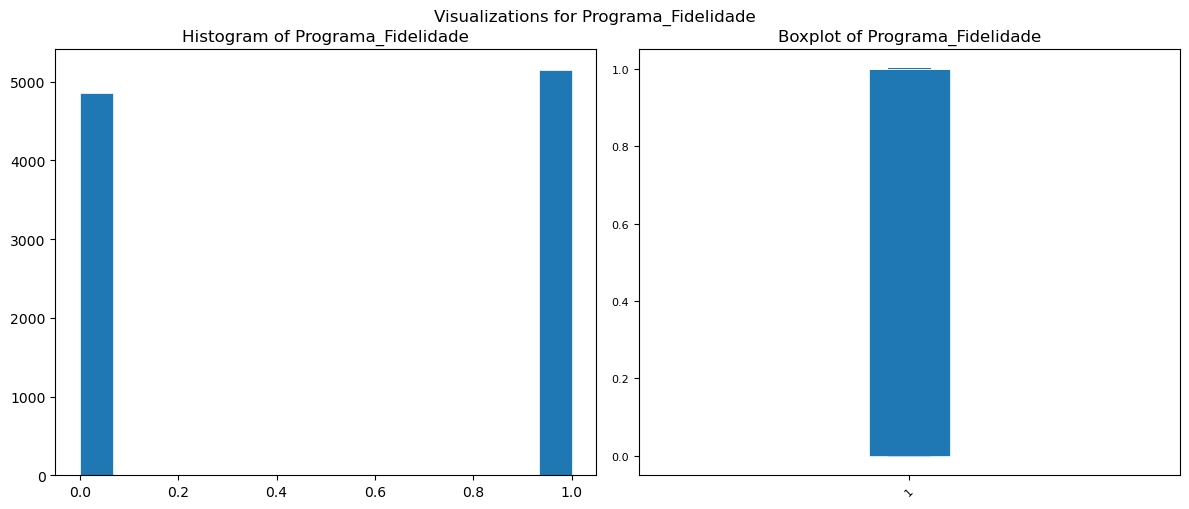

In [16]:
visualize_quantitative(quantitative_df)

## Analyzing Churn Distribution Across Numeric Features

In [17]:
def calculate_churn_by_all_columns(df):
    """
    Calculates the count and percentage of observations for each category in all numeric columns of the DataFrame.

    Args:
        df (pd.DataFrame): The DataFrame containing the data.

    Returns:
        dict: Dictionary containing counts and percentages of observations for each category in all numeric columns.
    """

    def calculate_count_and_percentage(df, column_name, total_rows):
        """
        Calculates the count and percentage of observations for each category in the specified column.

        Args:
            df (pd.DataFrame): The DataFrame containing the data.
            column_name (str): The name of the column for which to calculate categories and counts.
            total_rows (int): The total number of rows in the DataFrame.

        Returns:
            pd.DataFrame: Counts and percentages of observations for each category in the specified column.
        """

        # Calculate categories based on quartiles
        categories = pd.cut(df[column_name], bins=4)

        # Calculate counts by category
        count_by_category = df.groupby(categories)[column_name].count().reset_index(name='Count')
        count_by_category.columns = ['Category', 'Count']

        # Calculate percentages and format as percentages with two decimal places
        count_by_category['Percentage'] = count_by_category['Count'] / total_rows
        count_by_category['Percentage'] = count_by_category['Percentage'].apply(lambda x: f'{x:.2%}')

        return count_by_category

    count_percentage_by_column = {}

    # Get total number of rows in the DataFrame
    total_rows = df.shape[0]

    # Iterate over numeric columns
    numeric_columns = df.select_dtypes(include=[np.number]).columns
    for column_name in numeric_columns:
        # Calculate counts and percentages for the current column
        count_percentage_by_category = calculate_count_and_percentage(df, column_name, total_rows)

        # Store counts and percentages in the dictionary
        count_percentage_by_column[column_name] = count_percentage_by_category

    return count_percentage_by_column

In [18]:
# Calling
count_percentage_by_column = calculate_churn_by_all_columns(df)
# Loop through the dictionary and print each key and DataFrame
for key, value in count_percentage_by_column.items():
    print(f"-----> {key} <-----")  # Print the key with separators
    print(value.to_string())  # Print the DataFrame as a string
    print()  # Add a blank line for spacing

-----> ClientId <-----
                  Category  Count Percentage
0  (345558.001, 348067.75]   2500     25.00%
1    (348067.75, 350567.5]   2500     25.00%
2    (350567.5, 353067.25]   2500     25.00%
3    (353067.25, 355567.0]   2500     25.00%

-----> Dias Inativos <-----
          Category  Count Percentage
0  (-0.121, 30.25]   7987     79.87%
1    (30.25, 60.5]    638      6.38%
2    (60.5, 90.75]    698      6.98%
3   (90.75, 121.0]    677      6.77%

-----> Churn_Sim_Nao <-----
         Category  Count Percentage
0  (-0.001, 0.25]   7987     79.87%
1     (0.25, 0.5]      0      0.00%
2     (0.5, 0.75]      0      0.00%
3     (0.75, 1.0]   2013     20.13%

-----> Score_Credito <-----
         Category  Count Percentage
0  (349.5, 475.0]    357      3.57%
1  (475.0, 600.0]   2709     27.09%
2  (600.0, 725.0]   4664     46.64%
3  (725.0, 850.0]   2270     22.70%

-----> Idade <-----
         Category  Count Percentage
0  (17.926, 36.5]   4609     46.09%
1    (36.5, 55.0]   4591   

## Define column and step

In [19]:
df.dtypes

ClientId                   int64
DataÚltimaTransição       object
Dias Inativos              int64
Churn_Sim_Nao              int64
Score_Credito              int64
Estado                    object
G_nero                    object
Idade                      int64
Tempo_Cliente_Meses        int64
Limite_Credito_Mercado    object
Qte_Categorias             int64
Usa_Cartao_Credito         int64
Programa_Fidelidade        int64
 Sum_Acumulado            object
dtype: object

In [22]:
#Change column and size
column = 'Idade'  # Replace with the actual column name
step = 5  # Replace with the desired step size

In [23]:
import pandas as pd

def create_column_range_count_table(df: pd.DataFrame, column: str, column_min: int, column_max: int, step: int) -> pd.DataFrame:
    """
    Creates a count table based on a column and churn propensity.

    Args:
        df: The input DataFrame.
        column: The name of the column.
        column_min: The minimum value of the column.
        column_max: The maximum value of the column.
        step: The size of the range intervals.

    Returns:
        A DataFrame showing the number of people within each column range, their churn propensity, and frequency of churn.
    """

    # Create column bins
    column_bins = list(range(column_min, column_max + 1, step))
    column_bins.append(column_max + 1)  # Include all values

    # Create column range labels
    column_range_labels = [
        f"{start_column}-{end_column-1}"
        for start_column, end_column in zip(column_bins[:-1], column_bins[1:])
    ]

    # Add a column range column to the DataFrame
    df["Column Range"] = pd.cut(df[column], bins=column_bins, labels=column_range_labels, right=False)

    # Create a count table for people within each column range and churn propensity
    count_table = pd.crosstab(df["Column Range"], df[targetF])

    # Calculate frequency of churn for each category in percentage with two decimal places
    count_table['Frequency_Churn(%)'] = ((count_table[1] / count_table.sum(axis=1)) * 100).round(2)

    return count_table

# Call the function with the specified parameters
count_table = create_column_range_count_table(df, column, df[column].min(), df[column].max(), step)

# Print the key with separators
print(f"-----> {column} <-----")  

# Print the table with frequency values including '%' symbol
print(count_table.to_string(formatters={'Frequency_Churn(%)': '{:.2f}%'.format}))

-----> Idade <-----
Churn_Sim_Nao     0    1 Frequency_Churn(%)
Column Range                               
18-22           206   20              8.85%
23-27           741   53              6.68%
28-32          1632  138              7.80%
33-37          2050  247             10.75%
38-42          1653  366             18.13%
43-47           773  411             34.71%
48-52           324  346             51.64%
53-57           159  226             58.70%
58-62           163  133             44.93%
63-67           117   50             29.94%
68-72            87   20             18.69%
73-77            59    2              3.28%
78-82            17    0              0.00%
83-87             3    1             25.00%
88-92             3    0              0.00%
